In [68]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from torchvision import transforms
from omegaconf import OmegaConf as oc

%matplotlib inline
%config InlineBackend.figure_format='retina'

import models.utils as utils
import evals.embed_evals as evals
import utils.plot_data as plot
import utils.gen_triplets as gen
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## generated alignments

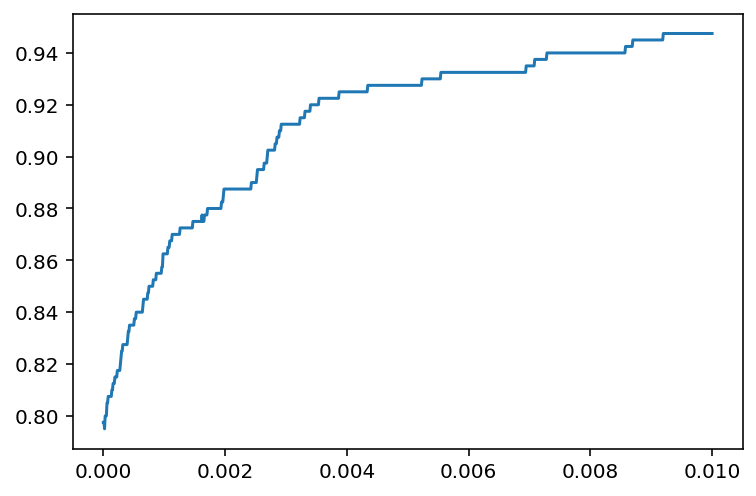

In [114]:
df = pd.read_csv("data_gen/search.csv")
plt.plot(df["weights"],df["aligns"])

In [121]:
df.iloc[269]

Unnamed: 0    269.000000
weights         0.002693
aligns          0.900000
Name: 269, dtype: float64

In [122]:
np.where(df["aligns"]==0.95)

(array([], dtype=int64),)

In [118]:
train_embeds = pickle.load(open("datasets/wv_3d/train_features.pkl","rb"))
test_embeds = pickle.load(open("datasets/wv_3d/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/train")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/test")])

In [124]:
evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, [1,0.011,1,1])

0.95

In [126]:
aligns=[]
w2s = [0,0.00075,0.002693,0.011,1]
for w2 in w2s:
    weights = [1,w2,1,1]
    aligns.append(evals.distorted_1nn(train_embeds, y_train, test_embeds, y_test, weights))
aligns

[0.7975, 0.85, 0.9, 0.95, 1.0]

In [100]:
a = np.array([1,1])
b = np.array([1,2])

In [103]:
evals.weightedPdist(a,b,[1,1]) < 2

array([[ True]])

## direct NI comparison

In [104]:
## filter out correct NIs
NIs = pd.read_csv("noise_NIs.csv")
RESN_NIs = pickle.load(open("embeds/wv_2d/RESN_d=50/RESN_NIs.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/weevil_vespula/train")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/weevil_vespula/test")])
syn_x_train = pickle.load(open("/net/scratch/tianh/explain_teach/embeds/wv_2d/train.pkl","rb"))
syn_x_test = pickle.load(open("/net/scratch/tianh/explain_teach/embeds/wv_2d/test.pkl","rb"))
def str2list(S): return [int(x) for x in S.replace("]"," ").replace("["," ").replace(",","").strip().split(" ")]

In [112]:
weights = [1,0]
nn_comparison = []
for NI in NIs["NI"]:
    NI = str2list(NI)
    NI = np.array(NI).reshape(-1,1)
    wins, errs, ties = evals.nn_comparison(syn_x_train, syn_x_test, NI, RESN_NIs[0].reshape(-1,1), weights)
    nn_comparison.append((wins + ties*0.5)/40)

In [20]:
NIs.to_csv("noise_NIs.csv",index=False)

In [68]:
count = 0
NIs = []
NI = []
a = open("temp/wv_NI.txt","r")
for line in a:
    line = line.replace("]"," ").replace("["," ").strip().split(" ")
    # print(line)
    for x in line:
        if len(NI)==40:
            NIs.append(NI)
            NI=[]
        if x.isdigit():
            NI.append(int(x))
            count += 1

## resn eval

In [61]:
resn_dir = "embeds/wv_2d/RESN_d=50"
train_embeds = [pickle.load(open(f"{resn_dir}/MTL_han_train_seed{seed}.pkl","rb")) for seed in range(10)]
test_embeds = [pickle.load(open(f"{resn_dir}/MTL_han_test_seed{seed}.pkl","rb")) for seed in range(10)]
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/weevil_vespula/train")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/weevil_vespula/test")])
syn_x_train = pickle.load(open("/net/scratch/tianh/explain_teach/embeds/wv_2d/train.pkl","rb"))
syn_x_test = pickle.load(open("/net/scratch/tianh/explain_teach/embeds/wv_2d/test.pkl","rb"))

In [77]:
powers = [2,2]
w2s = [0,0.0001,0.001,0.0025,0.005,0.05,1]
aligns = [0.7,0.775,0.8,0.85,0.9,0.95,1]
metric = ["NINO_ds_acc","rNINO_ds_acc","NIFO_ds_acc"]
align_results = pd.DataFrame()
NIs = []
for w2,align in zip(w2s,aligns):
    weights = [1,w2]
    results = []
    for z_train,z_test in zip(train_embeds,test_embeds):
        data = evals.syn_evals(z_train, y_train, z_test, y_test, syn_x_train, syn_x_test, weights, powers, k=3)
        NI = data["NIs"]
        data = {m: [data[m]] for m in metric}
        results.append(pd.DataFrame(data=data))
    NIs.append(NI)
    results = pd.concat(results)
    results.insert(0, "align", [align]*10)
    align_results = pd.concat([align_results, results])

In [8]:
pickle.dump(np.array(NIs),open("embeds/wv_2d/RESN_d=50/RESN_NIs.pkl","wb"))

In [78]:
align_results

,align,NINO_ds_acc,rNINO_ds_acc,NIFO_ds_acc
0,0.7,0.775,0.775,0.800
0,0.7,0.725,0.725,0.700
0,0.7,0.675,0.650,0.700
0,0.7,0.625,0.625,0.525
0,0.7,0.775,0.775,0.750
...,...,...,...,...
0,1.0,0.900,0.875,0.725
0,1.0,0.925,0.900,0.950
0,1.0,0.950,0.950,0.800
0,1.0,0.950,0.900,0.850


### triplet gen

In [125]:
train_features = pickle.load(open("datasets/wv_3d/train_features.pkl","rb"))
valid_features = pickle.load(open("datasets/wv_3d/valid_features.pkl","rb"))
test_features = pickle.load(open("datasets/wv_3d/test_features.pkl","rb"))
y_train = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/train")])
y_valid = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/valid")])
y_test = np.array([x[1] for x in torchvision.datasets.ImageFolder("datasets/wv_3d/test")])

In [127]:
w2s = [0,0.00075,0.002693,0.011,1]
aligns = [0.8,0.85,0.9,0.95,1]
total = 10000

triplet_dir = "datasets/wv_3d_triplets"
for w2,align in zip(w2s, aligns):
    weights = [1,w2,1,1] 
    train_triplets, valid_triplets, test_triplets, train_triplets_filtered, valid_triplets_filtered, test_triplets_filtered =\
        gen.get_alignment_filtered_triplets(train_features, valid_features, test_features, y_train, y_valid, y_test, weights, total)
    print(len(train_triplets_filtered)/len(train_triplets), len(valid_triplets_filtered)/len(valid_triplets), len(test_triplets_filtered)/len(test_triplets))
    # break
    align_dir = os.path.join(triplet_dir,f"align={str(align)}")
    if not os.path.isdir(align_dir): os.mkdir(align_dir)
    pickle.dump(train_triplets, open(f"{align_dir}/train_triplets.pkl", "wb"))
    pickle.dump(valid_triplets, open(f"{align_dir}/valid_triplets.pkl", "wb"))
    pickle.dump(test_triplets, open(f"{align_dir}/test_triplets.pkl", "wb"))
    pickle.dump(train_triplets_filtered, open(f"{align_dir}/train_triplets_filtered.pkl","wb"))
    pickle.dump(valid_triplets_filtered, open(f"{align_dir}/valid_triplets_filtered.pkl","wb"))
    pickle.dump(test_triplets_filtered, open(f"{align_dir}/test_triplets_filtered.pkl","wb"))

0.766875 0.757 0.7649
0.765 0.764 0.7678
0.76375 0.7625 0.773
0.759875 0.746 0.763
0.76775 0.7715 0.7798


In [128]:
train_triplets = pickle.load(open("datasets/wv_3d_triplets/align=0.8/train_triplets.pkl","rb"))
valid_triplets = pickle.load(open("datasets/wv_3d_triplets/align=0.8/valid_triplets.pkl","rb"))
test_triplets = pickle.load(open("datasets/wv_3d_triplets/align=0.8/test_triplets.pkl","rb"))
for p in [0.05,0.1, 0.2, 0.3, 0.4, 0.5]:
    dir = os.path.join("datasets/wv_3d_triplets/align=0.8_noisy",str(p))
    if not os.path.isdir(dir): os.mkdir(dir)
    train_noisy = gen.get_noisy_triplets(train_triplets, p)
    valid_noisy = gen.get_noisy_triplets(valid_triplets, p)
    test_noisy = gen.get_noisy_triplets(test_triplets, p)
    pickle.dump(train_noisy, open(f"{dir}/train_triplets.pkl","wb"))
    pickle.dump(valid_noisy, open(f"{dir}/valid_triplets.pkl","wb"))
    pickle.dump(test_noisy, open(f"{dir}/test_triplets.pkl","wb"))

## yaml generation

In [83]:
yaml_dir = "models/configs/wv_3d/align_triplets"
base = oc.load(f"{yaml_dir}/align=0.8.yaml")
w2s = [0,0.0008,0.003,0.0123,1]
aligns = [0.8,0.85,0.9,0.95,1]

In [57]:
for w2,align in zip(w2s, aligns):
    weights = [1,w2,1,1] 
    train_triplets = base.train_triplets.replace("0.8",str(align))
    valid_triplets = base.valid_triplets.replace("0.8",str(align))
    test_triplets = base.test_triplets.replace("0.8",str(align))
    wandb_group = base.wandb_group.replace("0.8",str(align))
    overwrite = {"weights":weights, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base,overwrite), f"models/configs/wv_3d/align_triplets/align={align}.yaml")

In [86]:
yaml_dir = "models/configs/wv_3d/filtered_triplets"
base_filtered = oc.load(f"{yaml_dir}/align=0.8_filtered.yaml")

In [87]:
for w2,align in zip(w2s, aligns):
    weights = [1,w2,1,1] 
    train_triplets = base_filtered.train_triplets.replace("0.8",str(align))
    valid_triplets = base_filtered.valid_triplets.replace("0.8",str(align))
    test_triplets = base_filtered.test_triplets.replace("0.8",str(align))
    wandb_group = base_filtered.wandb_group.replace("0.8",str(align))
    overwrite = {"weights":weights, "train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_filtered,overwrite), f"models/configs/wv_3d/filtered_triplets/align={align}_filtered.yaml")

In [98]:
yaml_dir = "models/configs/wv_3d/noisy_triplets"
base_noisy = oc.load(f"{yaml_dir}/noise=0.1.yaml")

In [99]:
for p in [0.1, 0.05,0.2, 0.3, 0.4, 0.5]:
    train_triplets = base_noisy.train_triplets.replace("0.1",str(p))
    valid_triplets = base_noisy.valid_triplets.replace("0.1",str(p))
    test_triplets = base_noisy.test_triplets.replace("0.1",str(p))
    wandb_group = base_noisy.wandb_group.replace("0.1",str(p))
    overwrite = {"train_triplets":train_triplets,"valid_triplets":valid_triplets,
    "test_triplets":test_triplets,"wandb_group":wandb_group}
    oc.save(oc.merge(base_noisy,overwrite), f"models/configs/wv_3d/noisy_triplets/noise={p}.yaml")

## cross validation

In [ ]:
c1, c2, c3, c4 = np.arange(1583), np.arange(1583,3166), np.arange(600,900), np.arange(900,1200)
splits = utils.cross_val_multiclass([c1,c2], 10)

In [ ]:
c1 = np.arange(1583)
valid_test = np.random.choice(c1, 300,replace=False)
c1_valid = np.random.choice(valid_test, 150, replace=False)
c1_test = np.setdiff1d(valid_test, c1_valid)
c1_train = np.setdiff1d(c1, valid_test)

In [ ]:
c2 = np.arange(1583,5856)
valid_test = np.random.choice(c2, 300,replace=False)
c2_valid = np.random.choice(valid_test, 150, replace=False)
c2_test = np.setdiff1d(valid_test, c2_valid)
c2_train = np.setdiff1d(c2, valid_test)

In [ ]:
pickle.dump(splits,open("models/pneumonia_splits_imb.pkl","wb"))

In [ ]:
src_dir = "/net/scratch/tianh-shared/warblers/inat/4class"
dst_dir = "/net/scratch/tianh-shared/warblers/data"
split5 = pickle.load(open("models/bird_splits.pkl","rb"))[5]

In [ ]:
train, val, test = split5
instances = utils.dataset_filenames(src_dir)

In [ ]:
labels = [v[1] for v in instances[train]]
unique = set(labels)
counts = [labels.count(c) for c in unique]
counts

In [ ]:
lambdas = np.arange(0.1, 1, 0.1)
clf = [0.875, 0.925, 0.95, 0.975, 0.975, 0.975, 1, 1, 0.975]
triplet = [0.897,0.913,0.913,0.855,0.841,0.826,0.841,0.841,0.841]

In [ ]:
lw=4
plt.rc('legend', fontsize=15)
plt.figure(figsize=(10,6))
plt.axhline(1, c='black',linewidth=lw, label="ResNET clf acc")
plt.plot(lambdas, clf,linewidth=lw, label="MTL clf acc")
plt.plot(lambdas, triplet,linewidth=lw, label="MTL triplet acc")
plt.axhline(0.841, c='green',linewidth=lw, label="TN triplet acc")
plt.xlabel('lambda')
# plt.title("MTL trained on human triplets")
plt.legend(loc='upper right', bbox_to_anchor=(1.1, -0.1),fancybox=True, shadow=True, ncol=4)
plt.savefig("figs/MTL_lambdas.pdf", format="pdf", bbox_inches="tight")

In [ ]:

triplets = pickle.load(open("/net/scratch/tianh/triplet-webapp/backup/trial0/butterfly.triplets.pkl","rb"))

In [ ]:
train_idx = pickle.load(open("data/bm_train_idx.pkl", "rb"))[1]
val_idx  = pickle.load(open("data/bm_valid_idx.pkl", "rb"))[1]

In [ ]:
train_triplets = []
val_triplets = []
for triplet in triplets:
    a,p,n = triplet
    if a in train_idx.keys() and p in train_idx.keys() and n in train_idx.keys():
        new = [train_idx[a], train_idx[p], train_idx[n]]
        train_triplets.append(new)
    elif a in val_idx.keys() and p in val_idx.keys() and n in val_idx.keys():
        new = [val_idx[a], val_idx[p], val_idx[n]]
        val_triplets.append(new)

In [ ]:

train_triplets = "/net/scratch/tianh/explain_teach/data/bm_triplets/3c2_unique=182/train_triplets.pkl"
valid_triplets = "/net/scratch/tianh/explain_teach/data/bm_triplets/3c2_unique=182/valid_triplets.pkl"
train_triplets = pickle.load(open(train_triplets, "rb"))
valid_triplets = pickle.load(open(valid_triplets, "rb"))

In [ ]:

train_lpips_distance = "/net/scratch/tianh/explain_teach/embeds/lpips/lpips.bm.train.pkl"
valid_lpips_distance = "/net/scratch/tianh/explain_teach/embeds/lpips/lpips.bm.valid.pkl"
train_lpips_distance = pickle.load(open(train_lpips_distance, "rb"))
valid_lpips_distance = pickle.load(open(valid_lpips_distance, "rb"))

In [ ]:
correct = 0
total = 0
for htriplet in train_triplets:
    total += 1
    a,p,n = htriplet[0], htriplet[1], htriplet[2]
    if train_lpips_distance[a, p] < train_lpips_distance[a, n]:
        correct += 1
correct/total


In [ ]:
correct = 0
total = 0
for htriplet in valid_triplets:
    total += 1
    a,p,n = htriplet[0], htriplet[1], htriplet[2]
    if valid_lpips_distance[a, p] < valid_lpips_distance[a, n]:
        correct += 1
correct/total


In [ ]:
# train_pairwise_distance= "embeds/lpips.bm.train.pkl" 
# valid_pairwise_distance= "embeds/lpips.bm.valid.pkl" 
# train_pairwise_distance = pickle.load(open(train_pairwise_distance, "rb"))
# valid_pairwise_distance = pickle.load(open(valid_pairwise_distance, "rb"))

train_triplets = "/net/scratch/tianh/explain_teach/data/bm_triplets/train_triplets.pkl"
valid_triplets = "/net/scratch/tianh/explain_teach/data/bm_triplets/valid_triplets.pkl"
train_triplets = pickle.load(open(train_triplets, "rb"))
valid_triplets = pickle.load(open(valid_triplets, "rb"))

In [ ]:
train = pickle.load(open("embeds/TN_bm_train.pkl","rb"))
valid = pickle.load(open("embeds/TN_bm_valid.pkl","rb"))
triplets = pickle.load(open("data/bm_triplets/val2train_triplets.pkl","rb"))

In [ ]:
acc = evals.val2train_triplet_acc(train, valid, triplets)
acc

In [ ]:
acc = evals.triplet_acc(train, train_triplets)
acc

In [ ]:
acc = evals.triplet_acc(valid, valid_triplets)
acc

In [ ]:

train_triplets = "/net/scratch/tianh/bm/triplets/train_triplets.pkl"
valid_triplets = "/net/scratch/tianh/bm/triplets/valid_triplets.pkl"
# clf_train_triplets = "/net/scratch/tianh/bm/triplets/clf_train_triplets.pkl"
# clf_valid_triplets = "/net/scratch/tianh/bm/triplets/clf_valid_triplets.pkl"

train_triplets = pickle.load(open(train_triplets, "rb"))

In [ ]:

train_dir = "/net/scratch/hanliu-shared/data/bm/train"
valid_dir = "/net/scratch/hanliu-shared/data/bm/valid"
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=utils.bm_transform())
valid_dataset = torchvision.datasets.ImageFolder(valid_dir, transform=utils.bm_transform())
train_inputs = torch.tensor(np.array([data[0].numpy() for data in train_dataset]))
valid_inputs = torch.tensor(np.array([data[0].numpy() for data in valid_dataset]))
train_labels = torch.tensor(np.array([data[1] for data in train_dataset]))
valid_labels = torch.tensor(np.array([data[1] for data in valid_dataset]))

In [ ]:
np.where(train_labels==0)

In [ ]:
a = pickle.load(open("/net/scratch/tianh/bm/triplets/clf_train_triplets.pkl","rb"))

In [ ]:
idx = np.random.choice(len(combs), 32, replace=False)
sample = combs[idx]
len(np.unique(sample.flatten()))

In [ ]:
import torch
a = torch.tensor(sample)

In [ ]:
torch.unique(torch.flatten(a))

In [ ]:
triplet_idx = []
for c in combs:
    x1, x2, x3 = c[0], c[1], c[2]
    if train_pairwise_distance[x1, x2] > train_pairwise_distance[x1, x3]:
        triplet_idx.append([x1, x3, x2])
    else:
        triplet_idx.append([x1, x2, x3])

In [ ]:
pickle.dump(np.array(triplet_idx), open('/net/scratch/tianh/bm/triplets/train_triplets.pkl',"wb"))

In [ ]:
a = pickle.load(open('/net/scratch/tianh/bm/triplets/train_triplets.pkl',"rb"))
a.shape

In [ ]:
np.array(triplet_idx).shape

In [ ]:
food100 = []
with open('/net/scratch/tianh/food100-dataset/all-triplets.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=' ', quotechar='|')
    for row in spamreader:
        food100.append(row)

In [ ]:

transform = transforms.Compose([
    transforms.Resize([230,230]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
data_dir = '/net/scratch/tianh/food100-dataset/images'
dataset = torchvision.datasets.ImageFolder(data_dir, transform=transform)
total_idx = np.arange(len(dataset))

In [ ]:
train_img_idx = np.random.choice(total_idx, int(len(total_idx)*0.615), replace=False)
valid_img_idx = np.setdiff1d(total_idx, train_img_idx)

train_data = torch.tensor(np.array([dataset[i][0].numpy() for i in train_img_idx]))
valid_data = torch.tensor(np.array([dataset[i][0].numpy() for i in valid_img_idx]))
train_label = torch.tensor(np.array([dataset[i][1] for i in train_img_idx]))
valid_label = torch.tensor(np.array([dataset[i][1] for i in valid_img_idx]))

valid_triplets = []
for t in triplets:
    if t[0] in valid_label and t[1] in valid_label and t[2] in valid_label:
        valid_triplets.append(t)
train_triplets = []
for t in triplets:
    if t[0] in train_label and t[1] in train_label and t[2] in train_label:
        train_triplets.append(t)
len(train_triplets), len(valid_triplets)

In [ ]:
41685/11018

In [ ]:
len(triplets)*0.2

In [ ]:
triplets = pickle.load(open("/net/scratch/tianh/food100-dataset/triplets_idx.pkl", "rb"))

In [ ]:
train_triplets

In [ ]:
total_idx = np.arange(100)
train_idx = np.random.choice(total_idx, len(total_idx)*8//10, replace=False)
valid_idx = np.setdiff1d(total_idx, train_idx)
train_triplets = 0
valid_triplets = 0
for t in triplets:
    if t[0] in train_idx:
        train_triplets += 1
    else:
        valid_triplets += 1
train_triplets/len(triplets), valid_triplets/len(triplets)

In [ ]:
path = "/net/scratch/tianh/food100-dataset/images"
dir_list = os.listdir(path)
dir_list

In [ ]:
import shutil
for image in dir_list:
    image_dir = os.path.join(path, image[:-4]) 
    if not os.path.exists(image_dir):
        os.mkdir(image_dir) 
        shutil.copy(os.path.join(path,image),image_dir)